<a href="https://colab.research.google.com/github/lgiesen/forest-height/blob/main/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount ('/content/drive', force_remount=True)
root_path = 'drive/MyDrive/Colab Notebooks/data/'

Mounted at /content/drive


## Data Exploration

- Understand data format
- Get a visual impression of the data

In [2]:
path_images = root_path + 'images/'
path_masks = root_path + 'masks/'

In [3]:
from os.path import isfile, join
def get_files(dir):
  from os import listdir
  onlyfiles = [f for f in listdir(dir) if isfile(join(dir, f))]
  print(onlyfiles)
get_files(dir = root_path + 'images/')

['image_000.npy', 'image_001.npy', 'image_002.npy', 'image_003.npy', 'image_004.npy', 'image_005.npy', 'image_006.npy', 'image_007.npy', 'image_008.npy', 'image_009.npy', 'image_010.npy', 'image_011.npy', 'image_012.npy', 'image_013.npy', 'image_014.npy', 'image_015.npy', 'image_016.npy', 'image_017.npy', 'image_018.npy', 'image_019.npy']


In [4]:
def path_exists(path):
  import os
  return os.path.exists(root_path + path)

In [5]:
import numpy as np
# load exemplary data
sat_path = 'images/image_004.npy'
if path_exists(sat_path):
  satellite = np.load(root_path + sat_path)
  print('satellite:',satellite.shape)
mask_path = 'masks/mask_004.npy'
if path_exists(mask_path):
  mask = np.load(root_path + mask_path)
  mask.shape
  print('mask:',satellite.shape)

satellite: (10, 1024, 1024)
mask: (10, 1024, 1024)


In [15]:
import matplotlib.pyplot as plt
def plot_img(img, is_satellite = True):
    #shape: satellite == (10, 1024, 1024), mask == (1, 1024, 1024)
    scale_by_range = False
    if is_satellite:
      if scale_by_range:
        # Source Tobias Zimmermann Learnweb (https://www.uni-muenster.de/LearnWeb/learnweb2/mod/forum/discuss.php?d=399109#p649271)
        # Extract Red, Green, and Blue bands
        red = img[2, :, :]
        green = img[1, :, :]
        blue = img[0, :, :]

        # Normalize the bands to [0, 1] range
        red_norm = (red - red.min()) / (red.max() - red.min())
        green_norm = (green - green.min()) / (green.max() - green.min())
        blue_norm = (blue - blue.min()) / (blue.max() - blue.min())

        # Stack the bands to create an RGB image
        scaled_img = np.stack((red_norm, green_norm, blue_norm), axis=-1)
      else:
        # Source Jan Learnweb (https://www.uni-muenster.de/LearnWeb/learnweb2/mod/forum/discuss.php?d=399109#p649940): 
        # "Sentinel-2 data does not contain RGB values as you would expect them. 
        # Instead, the values have to be seen as bottom-of-the-atmosphere surface 
        # reflectance values, ranging between 1 and 10.000. So by dividing the 
        # bands by 10.000, you would receive the scaling 0...1. However, as most 
        # of the image content has values below 3.000 and mainly clouds exceed 
        # that limit, you can also produce a visual representation by dividing 
        # by 3.000 and cutting off [higher] values" 
        scaled_img = satellite[[2,1,0]].transpose(1,2,0)/3000
    elif not is_satellite:
      scaled_img = (mask - np.min(mask)) / (np.amax(mask) - np.amin(mask))
      # TODO: scale with total max and min of all masks for comparability
      scaled_img = np.squeeze(scaled_img) # remove redundant dimension
      
      
    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(scaled_img)
    plt.axis('off')
    plt.show()

satellite: complete


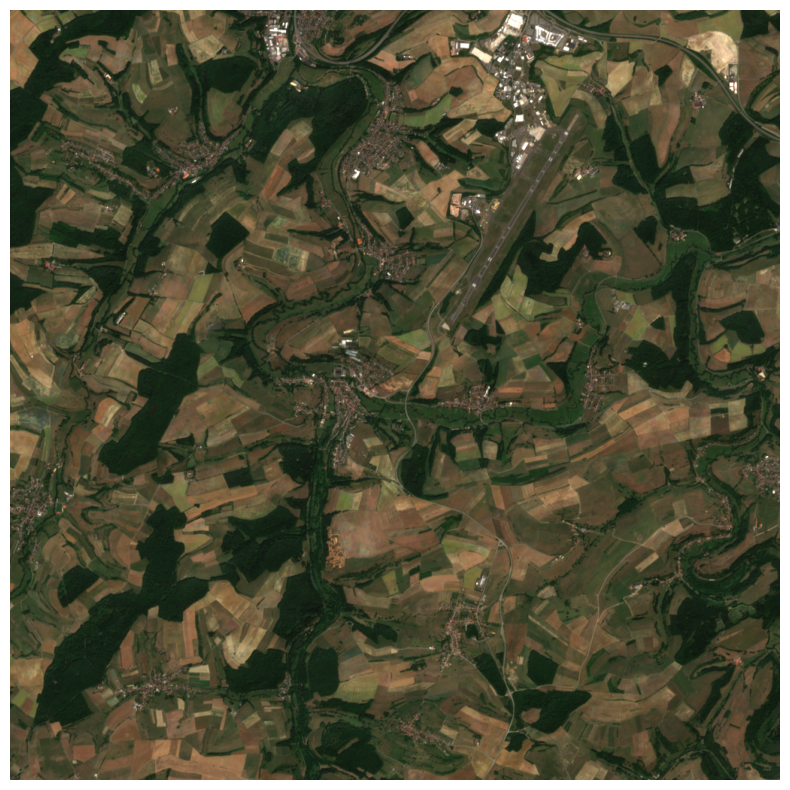

mask: complete


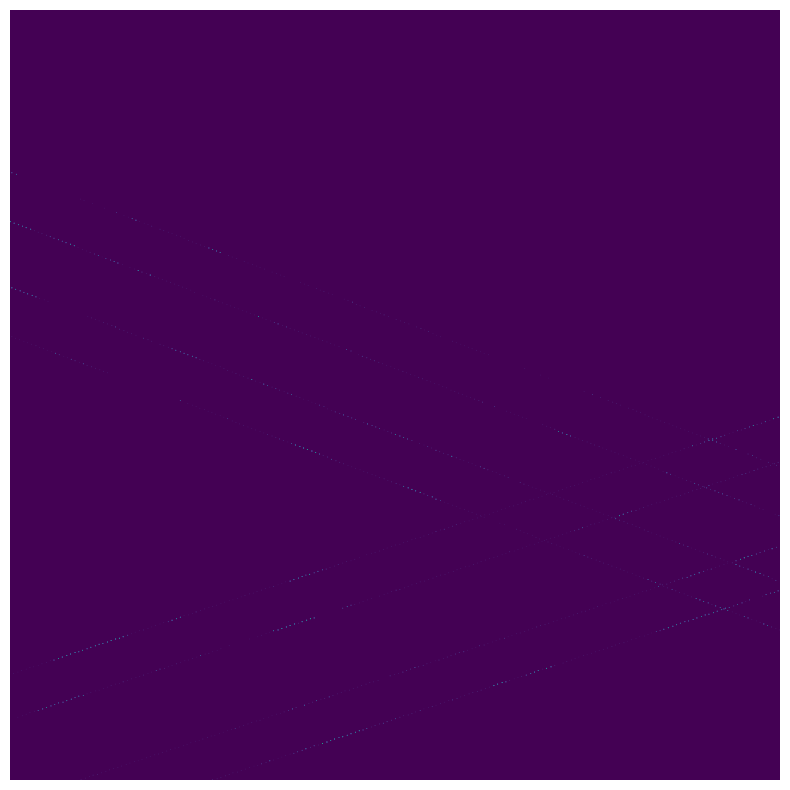

satellite: zoomed in


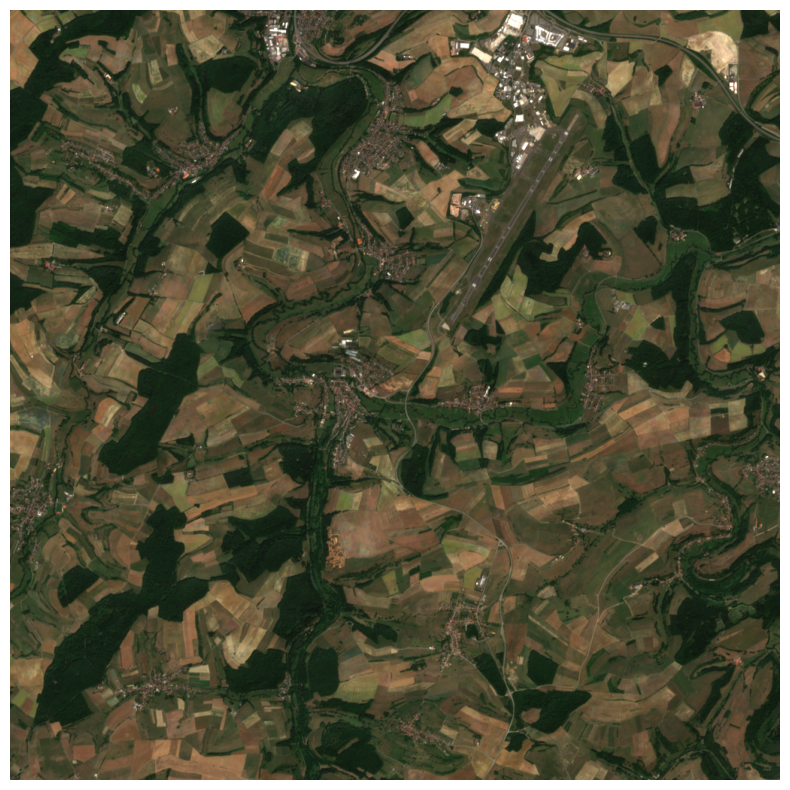

mask: zoomed in


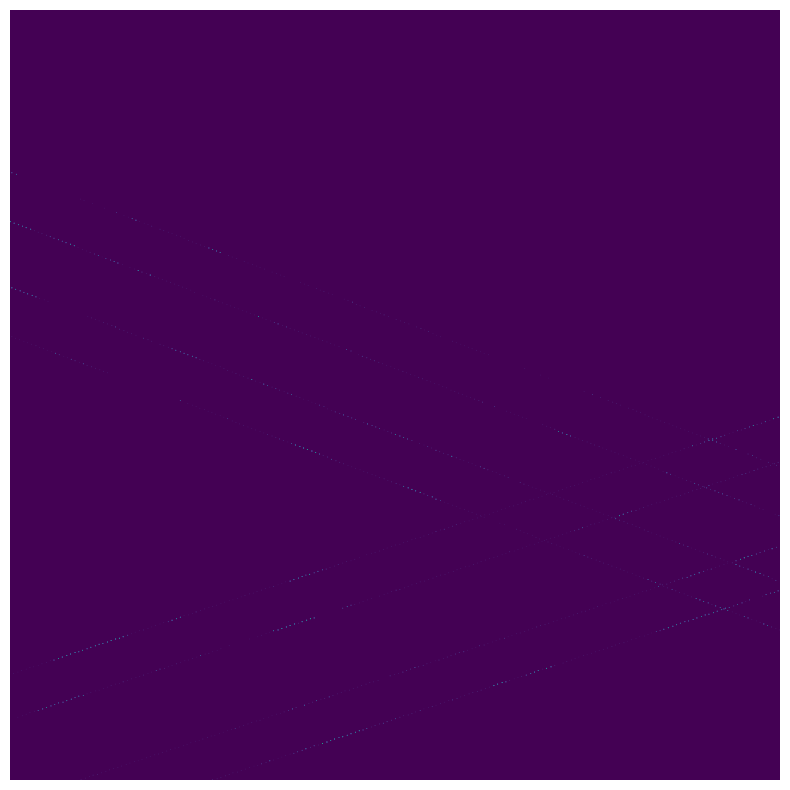

In [16]:
print("satellite: complete")
plot_img(satellite)
print("mask: complete")
plot_img(mask, is_satellite = False)
print("satellite: zoomed in")
plot_img(satellite[:,512:768,512:768])
print("mask: zoomed in")
plot_img(mask[:,512:768,512:768], is_satellite = False)

In [8]:
import matplotlib.pyplot as plt
def plot_mask_img(mask):
    
    scaled_img = (mask - np.min(mask)) / (np.amax(mask) - np.amin(mask))
    scaled_img = np.squeeze(scaled_img)
    # (mask - np.min(mask)) / (np.amax(mask) - np.amin(mask))
    # TODO: scale with total max and min of all masks for comparability

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(scaled_img)
    plt.axis('off')
    plt.show()

mask: complete


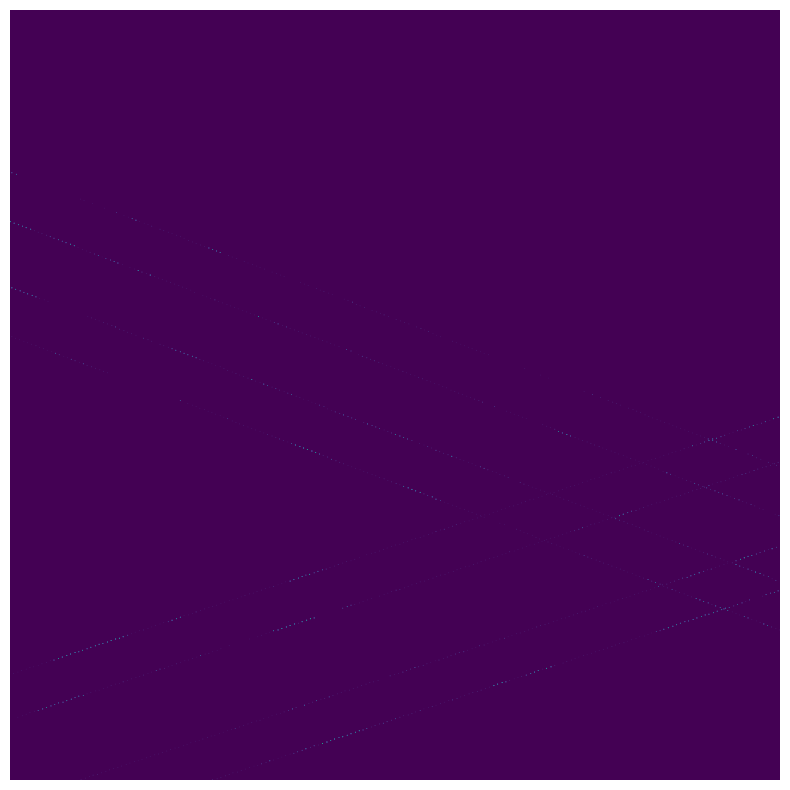

mask: zoomed in


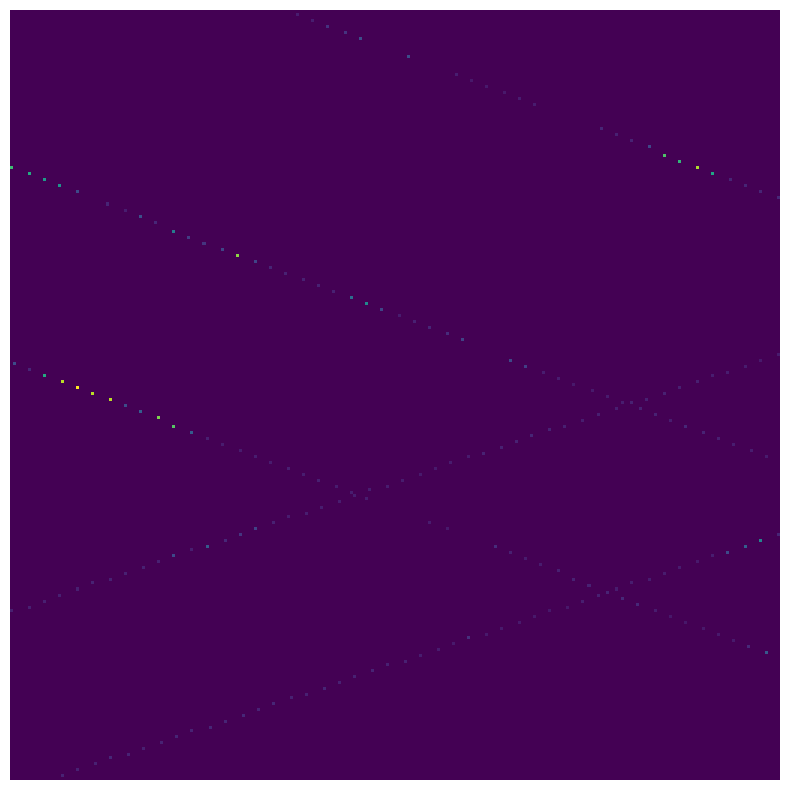

In [9]:
print("mask: complete")
plot_mask_img(mask)
print("mask: zoomed in")
plot_mask_img(mask[:,512:768,512:768])

The mask seems to have little dots of values, but not an area of trees, which is usual for a forest. Is that a case of low data quality or is the type of visualization faulty?

Answer: The labels are very sparse, 0s refer to missing values (majority of labels). The location of labels is not perfectly accurate (location up to 2 pixels inaccurate)

## Dataset Generation

The npy files are combined into a dataset. After the first loading they do not have to be generated anymore.
One npy file might need to be split into smaller images of 256x256 or 512x512 pixels, which then are put back together in the end.

In [10]:
# create data sets by combining npy files
path_train_sat = root_path + "train_satellite.npy"
path_train_masks = root_path + "train_masks.npy"

from os import listdir
if not isfile(path_train_sat):
  print("train satellite dataset is generated")
  # image set
  # initialize with the first satellite image
  train_satellite = np.load(path_images + listdir(path_images)[0])
  # concatinate all other images
  for f in listdir(path_images)[1:]:
      current_array = np.load(path_images + f, allow_pickle=True)
      train_satellite = np.concatenate((train_satellite, current_array), axis=0)
  # adjust incorrect shape: (200, 1024, 1024)
  train_satellite = train_satellite.reshape(20, 10, 1024, 1024)
  # save as file
  np.save(path_train_sat, train_satellite, allow_pickle=True, fix_imports=True)
if not isfile(path_train_masks):
  print("train masks dataset is generated")
  # masks
  # initialize with the first mask image
  train_masks = np.load(path_masks + listdir(path_masks)[0])
  # concatinate all other images
  for f in listdir(path_masks)[1:]:
      current_array = np.load(path_masks + f, allow_pickle=True)
      train_masks = np.concatenate((train_masks, current_array), axis=0)
  # save as file
  np.save(root_path + "train_masks.npy", train_masks, allow_pickle=True, fix_imports=True)

In [11]:
# remove drive connection as it is no longer needed
drive.flush_and_unmount()